# Práctica 2: Determinación de Tipos de Estrellas
Autores: Rodrigo Maroto Caño y Rodrigo Toldos Frutos  
Correos electrónicos: 100454455@alumnos.uc3m.es - 100454470@alumnos.uc3m.es   
Usuarios en GitHub: @RodrigoMaroto (owner) y @100454470   
Link del repositorio: https://github.com/RodrigoMaroto/Practica2-ML/

In [585]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.datasets import make_blobs
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.pipeline import Pipeline
from scipy import stats

np.random.seed(454455)

## 1. Implementación de K-means

In [586]:
def kmeans(X, n_clusters=2, max_iters=100):
    # Implementación de kmeans
    centroids = X[np.random.choice(X.shape[0], n_clusters, replace=False)]
    for _ in range(max_iters):
        distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
        labels = np.argmin(distances, axis=0)

        new_centroids = np.empty_like(centroids)
        for i in range(n_clusters):
            new_centroids[i] = X[labels == i].mean(axis=0)
        
        if np.allclose(new_centroids, centroids):
            break
        centroids = new_centroids
    return labels

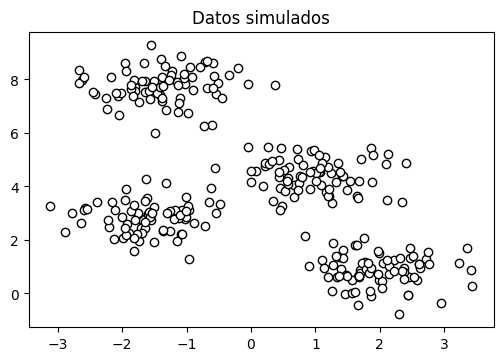

In [587]:
# Simulamos datos para comparar los rendimientos de nuestra implementación con los de sklearn
X, y = make_blobs(
    n_samples    = 300,
    n_features   = 2,
    centers      = 4,
    cluster_std  = 0.60,
    shuffle      = True,
    random_state = 0
)
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.scatter(
    x = X[:, 0],
    y = X[:, 1],
    c = 'white',
    marker    = 'o',
    edgecolor = 'black',
)
ax.set_title('Datos simulados');

In [588]:
X_scaled = scale(X)

In [589]:
%%timeit
y_predict = kmeans(X_scaled, 4)

7.56 ms ± 894 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [590]:
modelo_kmeans = KMeans(n_clusters=4, n_init=25, random_state=42)

In [591]:
%%timeit
modelo_kmeans.fit(X=X_scaled)
y_predict = modelo_kmeans.predict(X=X_scaled)

111 ms ± 9.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Se observa que la implementación de sklearn tiene tiempos de ejecución mayores, probablemente por la introducción de mejoras con respecto al kmeans básico.

In [592]:
y_predict = kmeans(X_scaled, 4)

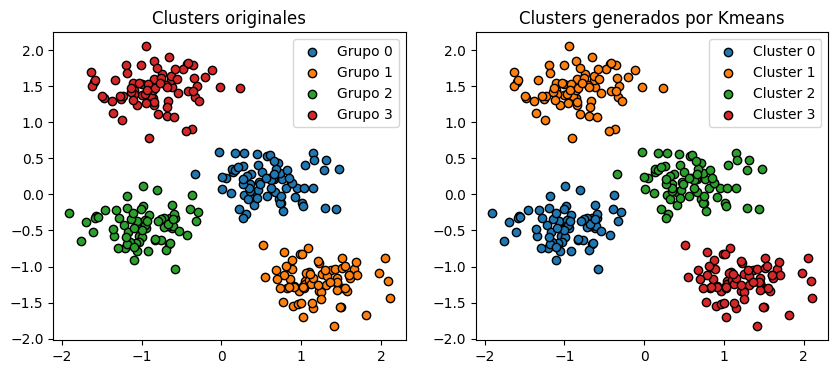

In [593]:
# Representación gráfica: grupos originales vs clusters creados
# ==============================================================================
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Grupos originales
for i in np.unique(y):
    ax[0].scatter(
        x = X_scaled[y == i, 0],
        y = X_scaled[y == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Grupo {i}"
    )

ax[0].set_title('Clusters originales')
ax[0].legend();

for i in np.unique(y_predict):
    ax[1].scatter(
        x = X_scaled[y_predict == i, 0],
        y = X_scaled[y_predict == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

ax[1].set_title('Clusters generados por Kmeans')
ax[1].legend();

## 2. Codificación de variables

In [594]:
df = pd.read_csv("stars_data.csv")

### Primera Opción: OneHotEncoding

In [595]:
# Vamos a utilizar el OneHotEncoder de scikit para las variables categóricas. Ponemos sparse_output = False para que se guarden los valores
# que son 0 también.

enc = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False).set_output(transform = 'pandas')
new_col_color = enc.fit_transform(df[['Color']])
new_col_sc = enc.fit_transform(df[['Spectral_Class']])

X_ohe = pd.concat([df, new_col_color, new_col_sc], axis = 1)
X_ohe.drop(columns = ['Color', 'Spectral_Class'], inplace = True)
features = X_ohe.columns


In [596]:
X_ohe_scaled = scale(X_ohe)
pca = PCA(n_components=2)
X_ohe_pca = pca.fit_transform(X_ohe_scaled)

Podemos visualizar cuánto influye cada característica para cada uno de los componentes del PCA:

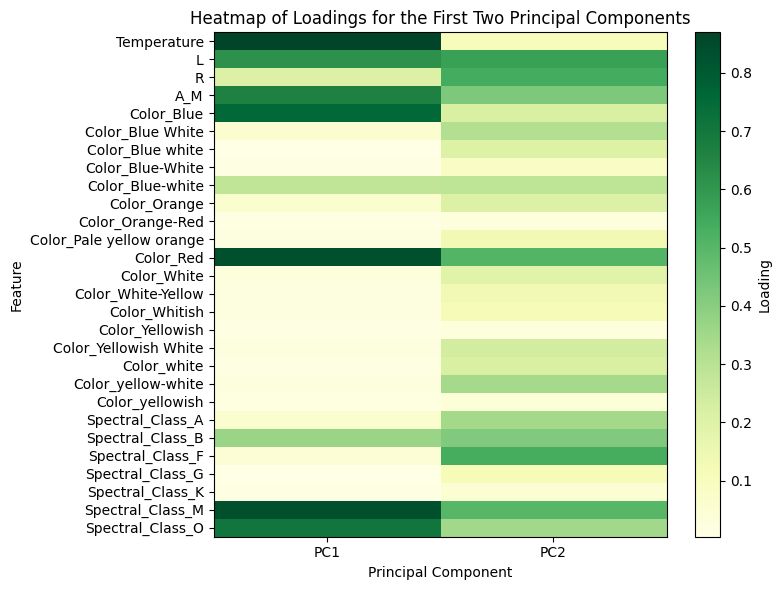

In [597]:
loadings = np.abs(pca.components_[:2].T * np.sqrt(pca.explained_variance_[:2]))

# Create a DataFrame for loadings
loadings_df = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index= features)

# Plot heatmap of loadings
plt.figure(figsize=(8, 6))
plt.title('Heatmap of Loadings for the First Two Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Feature')
plt.imshow(loadings_df, cmap='YlGn', aspect='auto')
plt.colorbar(label='Loading')
plt.xticks(ticks=np.arange(len(loadings_df.columns)), labels=loadings_df.columns)
plt.yticks(ticks=np.arange(len(loadings_df.index)), labels=loadings_df.index)
plt.tight_layout()
plt.show()

### Segunda Opción: Variable Ordinal

Como se indica en el enunciado, el color está asociado a la cantidad de energía, y algo parecido sucede con la clase espectral. Por tanto, puede tener sentido utilizar estas variables como ordinales, con el fin de representar una cercanía mayor entre dos cantidades de energía parecidas. Con OneHotEncoding no conservamos estas relaciones, ya que se utilizan como columnas independientes. Como se puede ver en la imagen, podemos establecer un orden atendiendo a la temperatura.


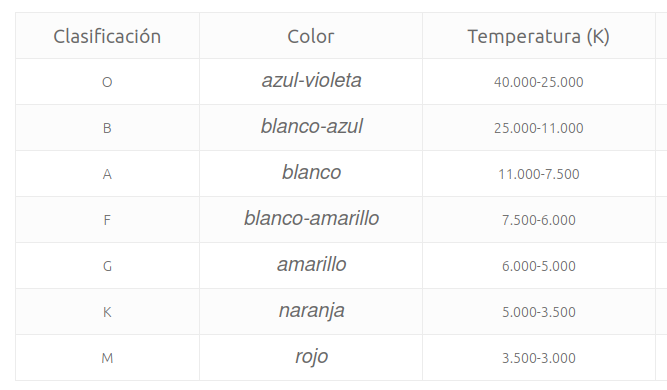

In [598]:
# Primero vamos a ver qué colores hay 
#print(df['Color'].unique())

#['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
#'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
#'Orange' 'White-Yellow' 'white' 'yellowish' 'Yellowish' 'Orange-Red'
#'Blue-White']

# Creamos un diccionario para sustituir esos nombres por valores que representen el orden

color_values = {"Red": 1, "Orange-Red": 2, "Orange": 3, "Pale yellow orange": 4, "yellowish": 5, "Yellowish": 5, "White-Yellow": 6,
                "yellow-white": 6,"Yellowish White": 6,"White": 7, "white": 7, "Whitish": 7, "Blue white": 8,"Blue White": 8,  
                "Blue-white": 8, "Blue-White": 8, "Blue": 9,
                }

df['Color'] = df['Color'].map(color_values)

# Hacemos lo mismo con la clase espectral

#print(df['Spectral_Class'].unique())
# ['M' 'B' 'A' 'F' 'O' 'K' 'G']

sc_values = {"M": 1, "K": 2, "G":3, "F":4, "A":5, "B":6, "O":7}
df['Spectral_Class'] = df['Spectral_Class'].map(sc_values)
features = df.columns


In [599]:
X_ord = df
X_ord_scaled = scale(df)
# Utilizamos pca para reducir la dimensionalidad
pca = PCA(n_components=2)
X_ord_pca = pca.fit_transform(X_ord_scaled)
X_ord

,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,1,1
1,3042,0.000500,0.1542,16.60,1,1
2,2600,0.000300,0.1020,18.70,1,1
3,2800,0.000200,0.1600,16.65,1,1
4,1939,0.000138,0.1030,20.06,1,1
...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,9,7
236,30839,834042.000000,1194.0000,-10.63,9,7
237,8829,537493.000000,1423.0000,-10.73,7,5
238,9235,404940.000000,1112.0000,-11.23,7,5


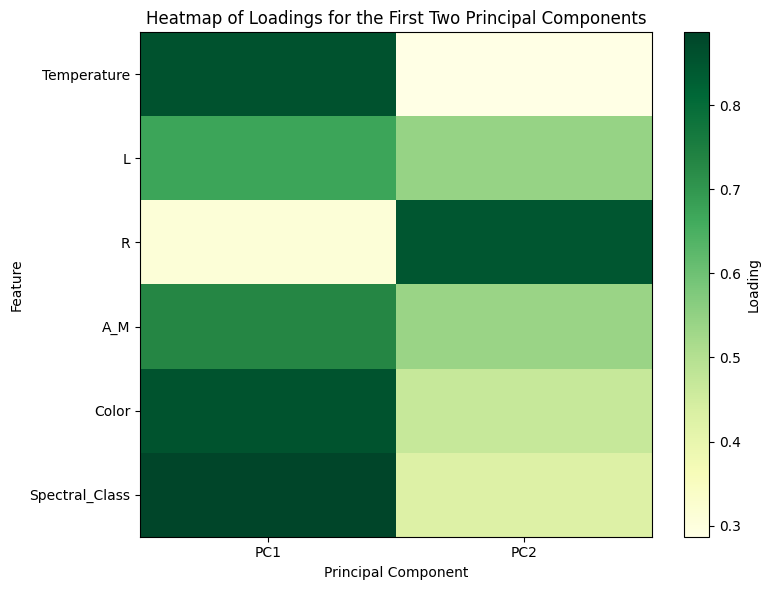

In [600]:
loadings = np.abs(pca.components_[:2].T * np.sqrt(pca.explained_variance_[:2]))

# Create a DataFrame for loadings
loadings_df = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index= features)

# Plot heatmap of loadings
plt.figure(figsize=(8, 6))
plt.title('Heatmap of Loadings for the First Two Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Feature')
plt.imshow(loadings_df, cmap='YlGn', aspect='auto')
plt.colorbar(label='Loading')
plt.xticks(ticks=np.arange(len(loadings_df.columns)), labels=loadings_df.columns)
plt.yticks(ticks=np.arange(len(loadings_df.index)), labels=loadings_df.index)
plt.tight_layout()
plt.show()

## 3. Algoritmos de Clustering

### K-means
En primer lugar, es necesario determinar el número óptimo de clústers.

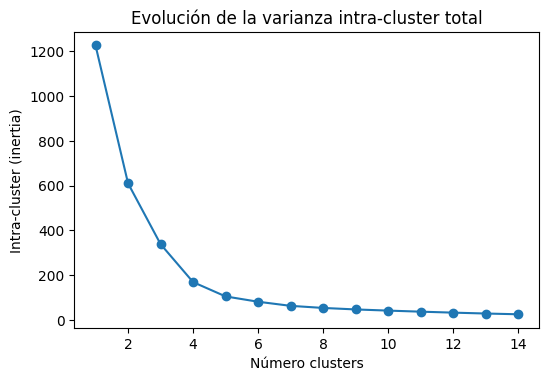

In [601]:
# Método elbow para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(1, 15)
inertias = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = 42
    )
    modelo_kmeans.fit(X_ord_pca)
    inertias.append(modelo_kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)');

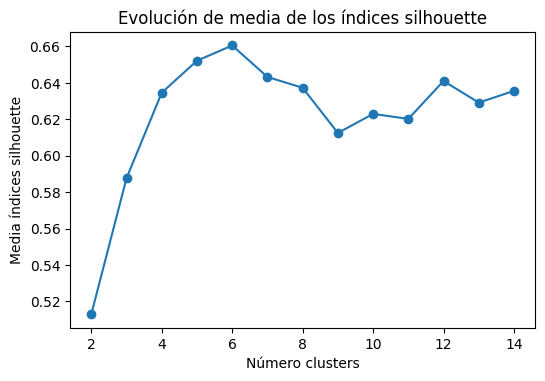

In [602]:
# Método silhouette para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = 123
    )
    cluster_labels = modelo_kmeans.fit_predict(X_ord_pca)
    silhouette_avg = silhouette_score(X_ord_pca, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

In [603]:
estadisticas = {}
modelo_kmeans = KMeans(n_clusters=6, random_state=100454455)
y_predict_kmeans = modelo_kmeans.fit_predict(X_ord_pca)

# Guardamos un nuevo dataframe en el que añadimos una nueva columna que contiene la etiqueta asignada
predicciones = pd.DataFrame({'label': y_predict_kmeans})
estadisticas['kmeans_ord'] = []
estadisticas['kmeans_ord'].append(len(np.unique(y_predict_kmeans)))
kmeans_ord_df = pd.concat([X_ord, predicciones], axis = 1)

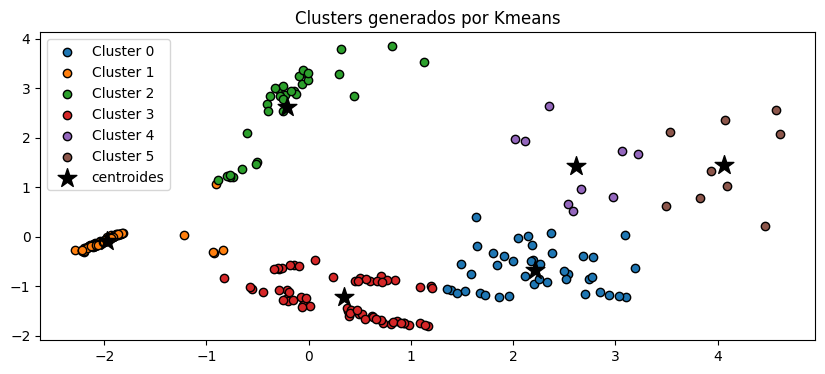

In [604]:
# Representación gráfica: grupos originales vs clusters creados
# ==============================================================================
fig, ax = plt.subplots(1, 1, figsize=(10, 4))


for i in np.unique(y_predict_kmeans):
    ax.scatter(
        x = X_ord_pca[y_predict_kmeans == i, 0],
        y = X_ord_pca[y_predict_kmeans == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

ax.scatter(
    x = modelo_kmeans.cluster_centers_[:, 0],
    y = modelo_kmeans.cluster_centers_[:, 1],
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'centroides'
)
ax.set_title('Clusters generados por Kmeans')
ax.legend();

### DBSCAN

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


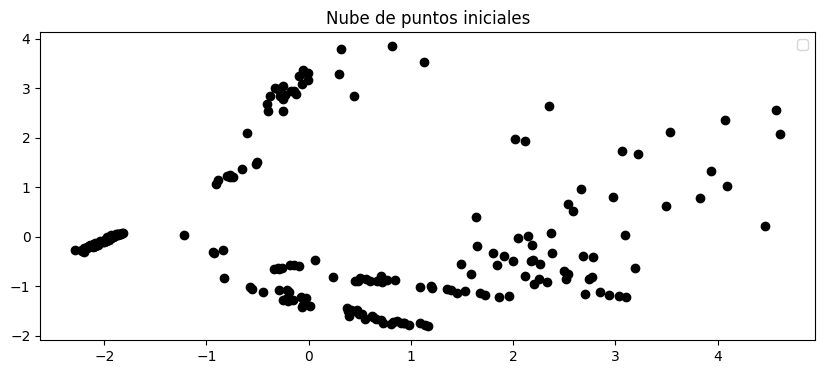

In [605]:
# Visualizado de datos
# ==============================================================================

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.scatter(
    x = X_ord_pca[:, 0],
    y = X_ord_pca[:, 1],
    c = 'black',
    marker    = 'o',
    edgecolor = 'black'
)
ax.legend()
ax.set_title('Nube de puntos iniciales');

Para encontrar un valor óptimo de la variable eps, se puede analizar el silhouette score para distintos valores, de manera que podamos encontrar un valor de eps que maximice la calidad del clustering

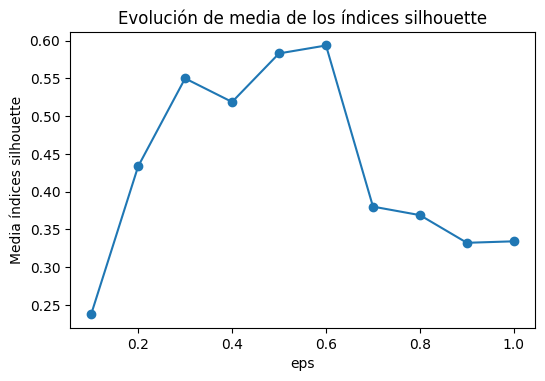

In [606]:
# Método silhouette para identificar el número óptimo de eps
# ==============================================================================
range_eps = np.arange(0.1, 1.1, 0.1)
range_eps = list(range_eps)
valores_medios_silhouette = []

for n_eps in range_eps:
    modelo_dbscan = DBSCAN(
    eps          = n_eps,
    min_samples  = 5,
    metric       = 'euclidean',
    )

    modelo_dbscan.fit(X_ord_pca)
    cluster_labels = modelo_dbscan.fit_predict(X_ord_pca)
    silhouette_avg = silhouette_score(X_ord_pca, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_eps, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('eps')
ax.set_ylabel('Media índices silhouette');

Por otro, lado, podemos proceder de igual manera para encontrar un valor óptimo del parámetro min_samples

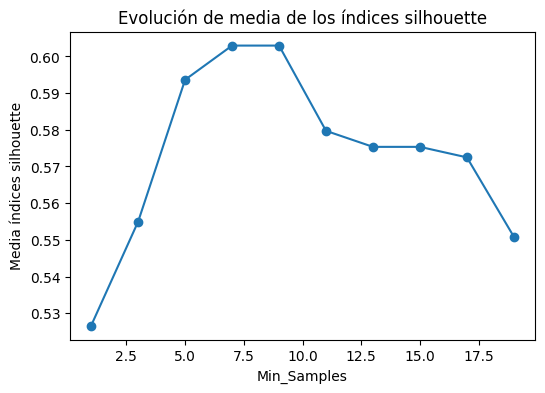

In [607]:
# Método silhouette para identificar el número óptimo de min_samples
# ==============================================================================
range_min_samples = range(1, 20, 2)

valores_medios_silhouette = []

for n_min_samples in range_min_samples:
    modelo_dbscan = DBSCAN(
    eps          = 0.6,
    min_samples  = n_min_samples,
    metric       = 'euclidean',
    )

    modelo_dbscan.fit(X_ord_pca)
    cluster_labels = modelo_dbscan.fit_predict(X_ord_pca)
    silhouette_avg = silhouette_score(X_ord_pca, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(range_min_samples, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Min_Samples')
ax.set_ylabel('Media índices silhouette');

In [608]:
modelo_dbscan = DBSCAN(
    eps          = 0.6,
    min_samples  = 7,
    metric       = 'euclidean',
)

modelo_dbscan.fit(X_ord_pca)

DBSCAN(eps=0.6, min_samples=7)

In [609]:
# Guardamos un nuevo dataframe en el que añadimos una nueva columna que contiene la etiqueta asignada
predicciones = pd.DataFrame({'label': modelo_dbscan.labels_})
estadisticas['dbscan_ord'] = []
estadisticas['dbscan_ord'].append(len(set(labels)) - (1 if -1 in labels else 0))
dbscan_ord_df = pd.concat([X_ord, predicciones], axis = 1)
dbscan_ord_df

,Temperature,L,R,A_M,Color,Spectral_Class,label
0,3068,0.002400,0.1700,16.12,1,1,0
1,3042,0.000500,0.1542,16.60,1,1,0
2,2600,0.000300,0.1020,18.70,1,1,0
3,2800,0.000200,0.1600,16.65,1,1,0
4,1939,0.000138,0.1030,20.06,1,1,0
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,9,7,-1
236,30839,834042.000000,1194.0000,-10.63,9,7,-1
237,8829,537493.000000,1423.0000,-10.73,7,5,-1
238,9235,404940.000000,1112.0000,-11.23,7,5,-1


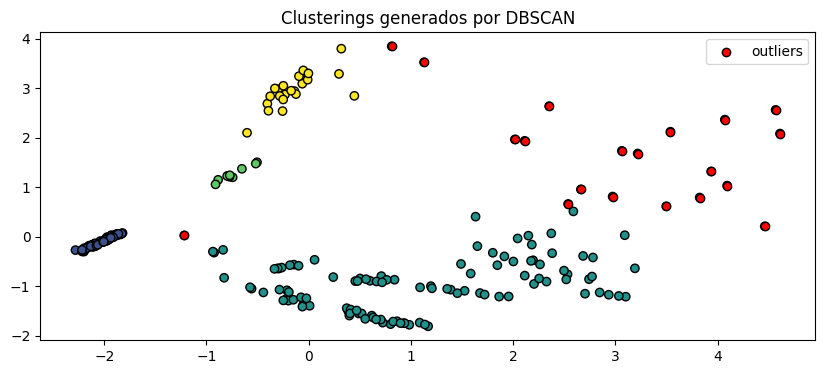

In [610]:
labels = modelo_dbscan.labels_

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.scatter(
    x = X_ord_pca[:, 0],
    y = X_ord_pca[:, 1],
    c = labels,
    marker    = 'o',
    edgecolor = 'black'
)

# Los outliers se identifican con el label -1
ax.scatter(
    x = X_ord_pca[labels == -1, 0],
    y = X_ord_pca[labels == -1, 1],
    c = 'red',
    marker    = 'o',
    edgecolor = 'black',
    label = 'outliers'
)

ax.legend()
ax.set_title('Clusterings generados por DBSCAN');

In [611]:
# Número de clusters y observaciones "outliers"
# ==============================================================================
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise    = list(labels).count(-1)

print(f'Número de clusters encontrados: {n_clusters}')
print(f'Número de outliers encontrados: {n_noise}')

Número de clusters encontrados: 4
Número de outliers encontrados: 20


### Comparación de resultados

En primer lugar, el algoritmo de kmeans es capaz de reconocer que el número de clústers óptimo es 6. Con elbow method se puede ver que el número de clústers es cercano a 6, mientras que si se utiliza el método de silhouette se puede ver claramente que el número de conjuntos que maximiza la calidad del clustering es 6. Por otro lado, el método DBSCAN, utilizando el método silhouette, determina que el número óptimo de clústers es 4. 

Por otro lado, el método de kmeans asigna a todos los elementos un clúster, mientras que DBSCAN deja 20 elementos sin clasificar (outliers).

Además, podemos comparar los valores de silueta de ambos métodos:

In [612]:
cluster_labels = modelo_dbscan.fit_predict(X_ord_pca)
silhouette_avg = silhouette_score(X_ord_pca, cluster_labels)
estadisticas['kmeans_ord'].append(silhouette_avg)
silhouette_avg

0.6029367567602255

In [613]:
cluster_labels = modelo_kmeans.fit_predict(X_ord_pca)
silhouette_avg = silhouette_score(X_ord_pca, cluster_labels)
estadisticas['dbscan_ord'].append(silhouette_avg)
silhouette_avg

0.6399882045639228

Para el método DBSCAN se ha obtenido un valor medio de silueta de 0.603, mientras que para kmeans se ha obtenido un valor medio de 0.634. Este valor representa cuán parecido es un valor al clúster que se le ha asignado comparado con los otros clústeres. Por tanto un valor más alto en esta métrica indica una mayor afinidad de un elemento con el clúster al que ha sido asignado. En nuestro caso, hemos obtenido un valor mejor para kmeans, lo que nos indica una mayor calidad del clustering.

Por otro lado, podemos fijarnos en otras métricas para analizar en mayor profundidad ambos métodos. Por ejemplo, el coeficiente de Calinski and Harabasz, que se define como la razón entre la dispersión entre clusters y la dispersión intra-cluster multiplicada por un factor de corrección. Este coeficiente es útil para analizar la calidad y cohesión de los clústers, es decir, un valor más alto de este coeficiente indica que los clústers están mejor definidos:

In [614]:
kmeans_calinski_harabasz_score = calinski_harabasz_score(X_ord_pca, y_predict_kmeans)
estadisticas['kmeans_ord'].append(kmeans_calinski_harabasz_score)
kmeans_calinski_harabasz_score

557.3726258602312

In [615]:
labels = modelo_dbscan.labels_
X_sin_outliers = X_ord_pca[labels != -1]
dbscan_calinski_harabasz_score = calinski_harabasz_score(X_sin_outliers, labels[labels != -1])
estadisticas['dbscan_ord'].append(kmeans_calinski_harabasz_score)
dbscan_calinski_harabasz_score

332.3017482948994

En los resultados obtenidos se puede apreciar que para kmeans los clústers se encuentran más cohesionados, es decir, hay una mayor separación entre los diferentes grupos y una menor dispersión dentro de los grupos. 

## 4. Comparación de codificación de variables categóricas 

Realizamos los mismos entrenamientos que en el apartado 3, usando los datos con One Hot Encoding.

### K-means
En primer lugar, es necesario determinar el número optimo de clústers.

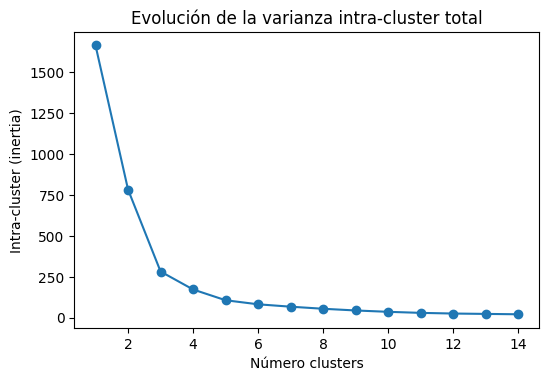

In [616]:
# Método elbow para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(1, 15)
inertias = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = 42
    )
    modelo_kmeans.fit(X_ohe_pca)
    inertias.append(modelo_kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)');

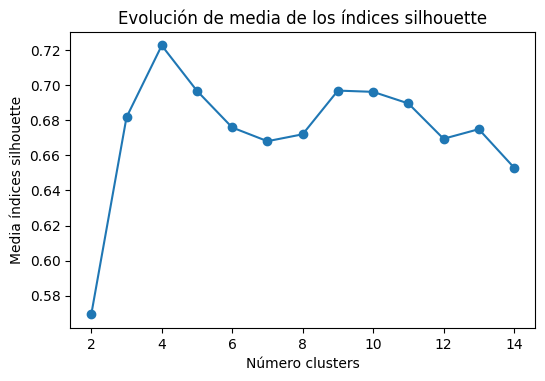

In [617]:
# Método silhouette para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = 123
    )
    cluster_labels = modelo_kmeans.fit_predict(X_ohe_pca)
    silhouette_avg = silhouette_score(X_ohe_pca, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

In [618]:
modelo_kmeans = KMeans(n_clusters=4, random_state=100454455)
y_predict = modelo_kmeans.fit_predict(X_ohe_pca)

In [619]:
# Guardamos un nuevo dataframe en el que añadimos una nueva columna que contiene la etiqueta asignada
predicciones = pd.DataFrame({'label': y_predict})
kmeans_ohe_df = pd.concat([X_ohe, predicciones], axis = 1)
kmeans_ohe_df

,Temperature,L,R,A_M,Color_Blue,Color_Blue White,Color_Blue white,Color_Blue-White,Color_Blue-white,Color_Orange,...,Color_yellow-white,Color_yellowish,Spectral_Class_A,Spectral_Class_B,Spectral_Class_F,Spectral_Class_G,Spectral_Class_K,Spectral_Class_M,Spectral_Class_O,label
0,3068,0.002400,0.1700,16.12,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
1,3042,0.000500,0.1542,16.60,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
2,2600,0.000300,0.1020,18.70,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
3,2800,0.000200,0.1600,16.65,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
4,1939,0.000138,0.1030,20.06,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
236,30839,834042.000000,1194.0000,-10.63,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
237,8829,537493.000000,1423.0000,-10.73,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
238,9235,404940.000000,1112.0000,-11.23,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0


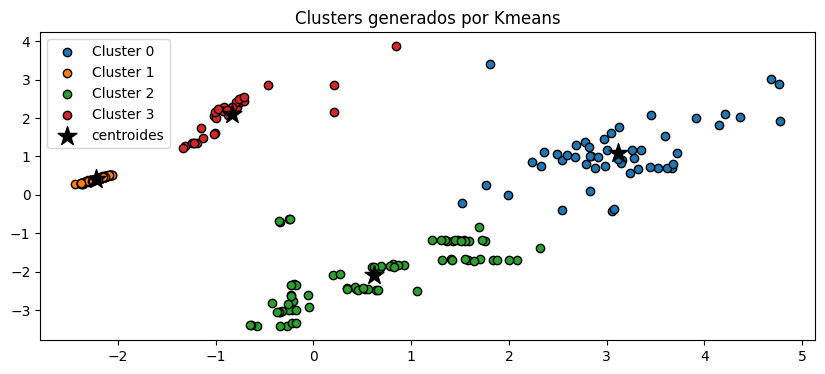

In [620]:
# Representación gráfica: grupos originales vs clusters creados
# ==============================================================================
fig, ax = plt.subplots(1, 1, figsize=(10, 4))


for i in np.unique(y_predict):
    ax.scatter(
        x = X_ohe_pca[y_predict == i, 0],
        y = X_ohe_pca[y_predict == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

ax.scatter(
    x = modelo_kmeans.cluster_centers_[:, 0],
    y = modelo_kmeans.cluster_centers_[:, 1],
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'centroides'
)
ax.set_title('Clusters generados por Kmeans')
ax.legend();

El cambio más significativo es que utilizando OneHotEncoding se obtiene como resultado óptimo una clasificación en 4 clústeres en vez de los 6 que se obtienen utilizando una variable de carácter ordinal. 

In [621]:
estadisticas['kmeans_ohe'] = []
cluster_labels = modelo_kmeans.fit_predict(X_ohe_pca)
silhouette_avg = silhouette_score(X_ohe_pca, cluster_labels)
estadisticas['kmeans_ohe'].append(len(np.unique(y_predict)))
estadisticas['kmeans_ohe'].append(silhouette_avg)
silhouette_avg


0.7222059350391841

In [622]:
kmeans_calinski_harabasz_score = calinski_harabasz_score(X_ohe_pca, y_predict)
estadisticas['kmeans_ohe'].append(kmeans_calinski_harabasz_score)
kmeans_calinski_harabasz_score

680.4056078555784

Al analizar el coeficiente medio de silueta, así como el coeficiente de Calinski Harabasz para este nuevo modelo, se aprecia una mejora en éstos con respecto al anterior. Sin embargo, esto sucede porque los elementos han cambiado y con estos nuevos datos, aparecen grupos menos dispersos. Pero esto no significa que el modelo sea capaz de hacer mejores predicciones que el anterior. Posteriormente, para decantarnos por un pipeline, observaremos cómo de dispersos están los datos en cada una de las características para los clústers.

### DBSCAN

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


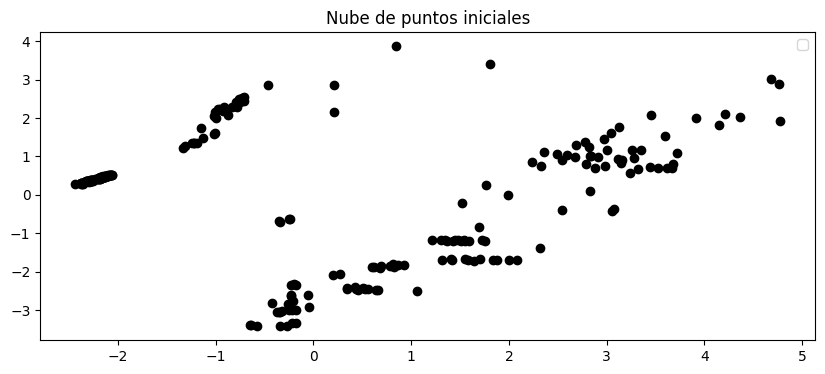

In [623]:
# Visualizado de datos
# ==============================================================================

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.scatter(
    x = X_ohe_pca[:, 0],
    y = X_ohe_pca[:, 1],
    c = 'black',
    marker    = 'o',
    edgecolor = 'black'
)
ax.legend()
ax.set_title('Nube de puntos iniciales');

Volvemos a buscar los valores óptimos para los parámetros eps y min_samples

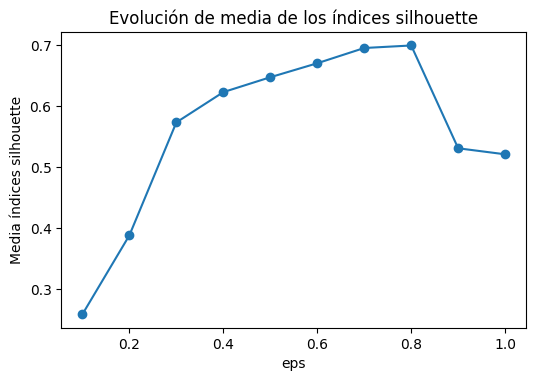

In [624]:
# Método silhouette para identificar el número óptimo de eps
# ==============================================================================
range_eps = np.arange(0.1, 1.1, 0.1)
range_eps = list(range_eps)
valores_medios_silhouette = []

for n_eps in range_eps:
    modelo_dbscan = DBSCAN(
    eps          = n_eps,
    min_samples  = 5,
    metric       = 'euclidean',
    )

    modelo_dbscan.fit(X_ohe_pca)
    cluster_labels = modelo_dbscan.fit_predict(X_ohe_pca)
    silhouette_avg = silhouette_score(X_ohe_pca, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_eps, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('eps')
ax.set_ylabel('Media índices silhouette');

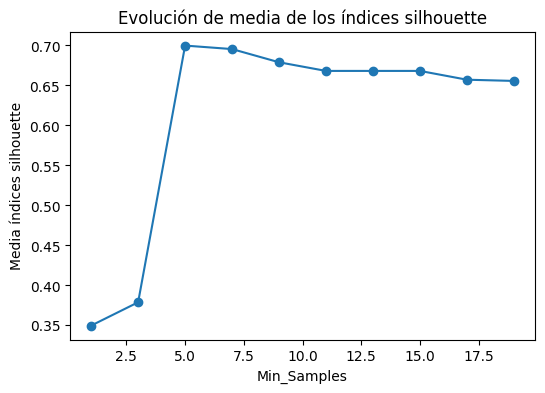

In [625]:
# Método silhouette para identificar el número óptimo de min_samples
# ==============================================================================
range_min_samples = range(1, 20, 2)

valores_medios_silhouette = []

for n_min_samples in range_min_samples:
    modelo_dbscan = DBSCAN(
    eps          = 0.8,
    min_samples  = n_min_samples,
    metric       = 'euclidean',
    )

    modelo_dbscan.fit(X_ohe_pca)
    cluster_labels = modelo_dbscan.fit_predict(X_ohe_pca)
    silhouette_avg = silhouette_score(X_ohe_pca, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(range_min_samples, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Min_Samples')
ax.set_ylabel('Media índices silhouette');

In [626]:
modelo_dbscan = DBSCAN(
    eps          = 0.8,
    min_samples  = 5,
    metric       = 'euclidean',
)

modelo_dbscan.fit(X_ohe_pca)

DBSCAN(eps=0.8)

In [627]:
# Guardamos un nuevo dataframe en el que añadimos una nueva columna que contiene la etiqueta asignada
predicciones = pd.DataFrame({'label': modelo_dbscan.labels_})
dbscan_ohe_df = pd.concat([X_ohe, predicciones], axis = 1)
dbscan_ohe_df

,Temperature,L,R,A_M,Color_Blue,Color_Blue White,Color_Blue white,Color_Blue-White,Color_Blue-white,Color_Orange,...,Color_yellow-white,Color_yellowish,Spectral_Class_A,Spectral_Class_B,Spectral_Class_F,Spectral_Class_G,Spectral_Class_K,Spectral_Class_M,Spectral_Class_O,label
0,3068,0.002400,0.1700,16.12,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,3042,0.000500,0.1542,16.60,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,2600,0.000300,0.1020,18.70,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,2800,0.000200,0.1600,16.65,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,1939,0.000138,0.1030,20.06,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2
236,30839,834042.000000,1194.0000,-10.63,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1
237,8829,537493.000000,1423.0000,-10.73,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2
238,9235,404940.000000,1112.0000,-11.23,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1


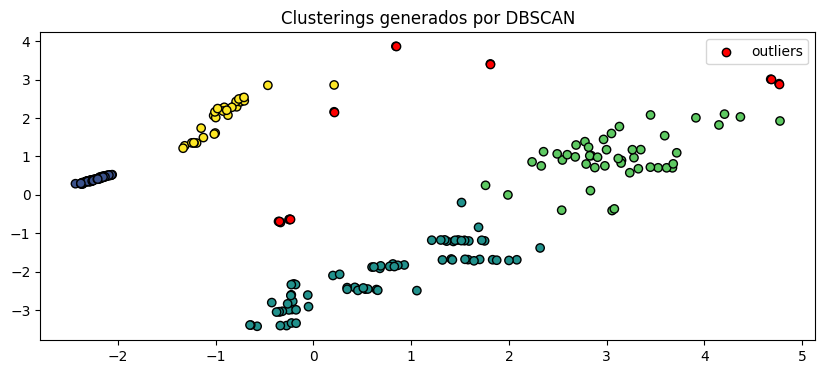

In [628]:
labels = modelo_dbscan.labels_
estadisticas['dbscan_ohe'] = []
estadisticas['dbscan_ohe'].append(len(set(labels)) - (1 if -1 in labels else 0))
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.scatter(
    x = X_ohe_pca[:, 0],
    y = X_ohe_pca[:, 1],
    c = labels,
    marker    = 'o',
    edgecolor = 'black'
)

# Los outliers se identifican con el label -1
ax.scatter(
    x = X_ohe_pca[labels == -1, 0],
    y = X_ohe_pca[labels == -1, 1],
    c = 'red',
    marker    = 'o',
    edgecolor = 'black',
    label = 'outliers'
)

ax.legend()
ax.set_title('Clusterings generados por DBSCAN');

In [629]:
# Número de clusters y observaciones "outliers"
# ==============================================================================
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise    = list(labels).count(-1)

print(f'Número de clusters encontrados: {n_clusters}')
print(f'Número de outliers encontrados: {n_noise}')

Número de clusters encontrados: 4
Número de outliers encontrados: 9


Para este modelo, la principal diferencia que se aprecia con respecto al uso de variables ordinales, es que cambia el valor óptimo de eps, subiendo a 0.8, mientras que min_samples queda fijado a 5. En cuanto a los resultados, en este caso hay 9 outliers, menos que en el otro caso. Si analizamos los coeficientes:

In [630]:
cluster_labels = modelo_dbscan.fit_predict(X_ohe_pca)
silhouette_avg = silhouette_score(X_ohe_pca, cluster_labels)
estadisticas['dbscan_ohe'].append(silhouette_avg)
silhouette_avg

0.6997972885071687

In [631]:
labels = modelo_dbscan.labels_
X_sin_outliers = X_ohe_pca[labels != -1]
dbscan_calinski_harabasz_score = calinski_harabasz_score(X_sin_outliers, labels[labels != -1])
estadisticas['dbscan_ohe'].append(dbscan_calinski_harabasz_score)
dbscan_calinski_harabasz_score

808.2244641809843

Al igual que con kmeans, se ve que ambos coeficientes han mejorado por los mismos motivos. En ambos casos, el uso de OneHotEncoding arroja coeficientes mejores, aunque, como se ha explicado previamente, será necesario un análisis mayor para determinar qué modelo usar, ya que los coeficientes por sí mismos no indican cómo de bien es capaz de clasificar un modelo de clustering. En el siguiente DataFrame, se puede observar un resumen de los coeficientes obtenidos para los diferentes métodos.

In [632]:
estadisticas_df = pd.DataFrame(estadisticas.values(), columns = ['n_clusters', 'Silhouette', 'Calinski Harabasz'], index = estadisticas.keys())
estadisticas_df

,n_clusters,Silhouette,Calinski Harabasz
kmeans_ord,6,0.602937,557.372626
dbscan_ord,4,0.639988,557.372626
kmeans_ohe,4,0.722206,680.405608
dbscan_ohe,4,0.699797,808.224464


## 5. Pipeline

A continuación, con el fin de visualizar qué clasificación arroja datos mejor diferenciados, se muestra un histograma para cada característica analizada.

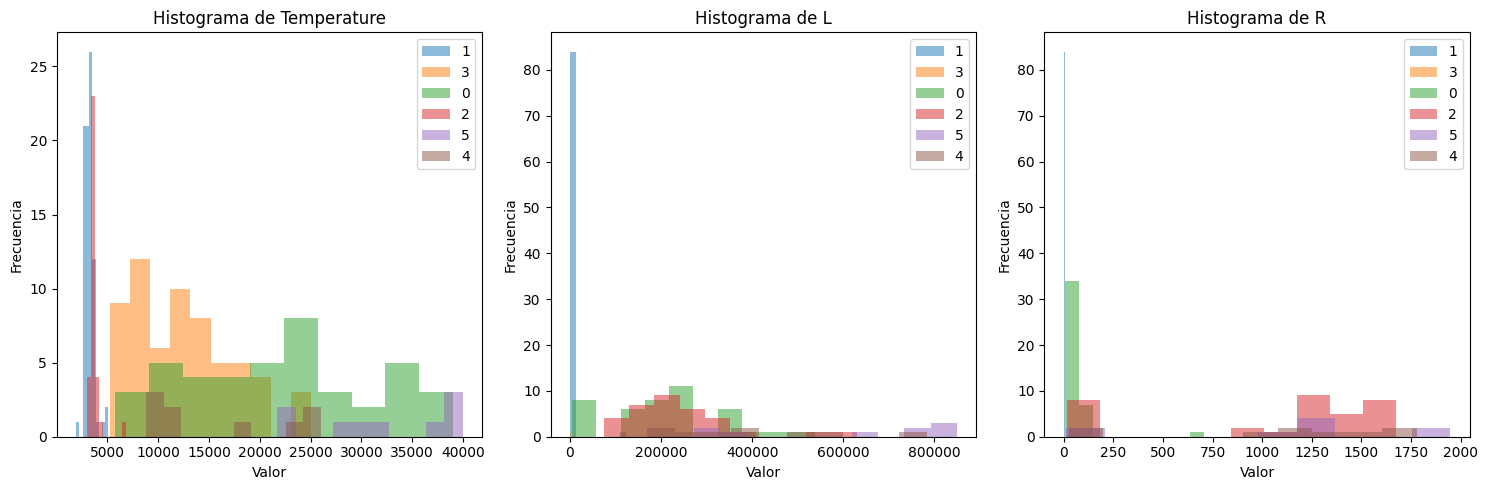

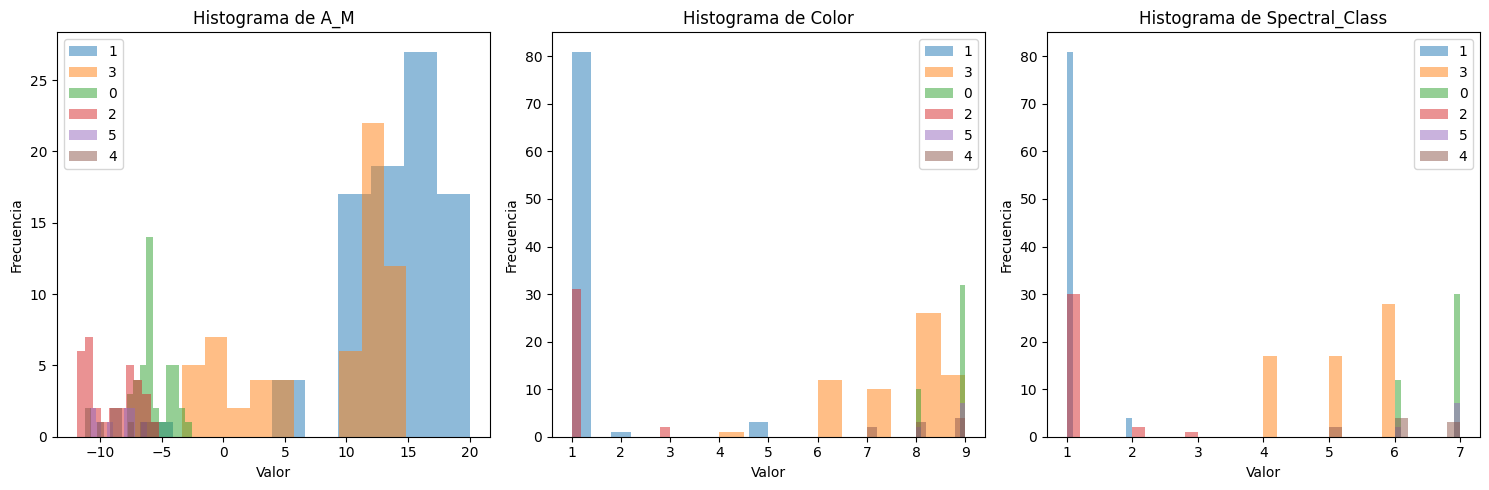

In [633]:
df = kmeans_ord_df
labels = df['label'].unique()
column_groups = [df.columns[i:i+3] for i in range(0, len(df.columns)-1, 3)]

for group in column_groups:
    fig, axs = plt.subplots(1, len(group), figsize=(15, 5))
    for i, column in enumerate(group):
        for label in labels:
            axs[i].hist(df[df['label'] == label][column], alpha=0.5, label=label)
        axs[i].set_title('Histograma de {}'.format(column))
        axs[i].set_xlabel('Valor')
        axs[i].set_ylabel('Frecuencia')
        axs[i].legend()
    plt.tight_layout()
    plt.show()

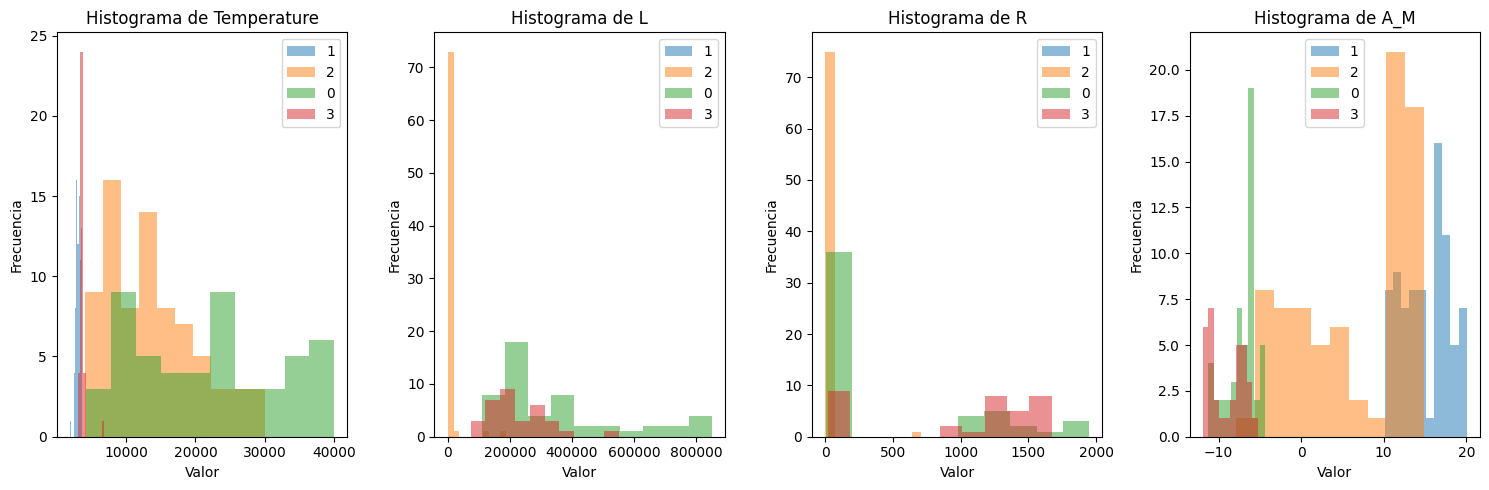

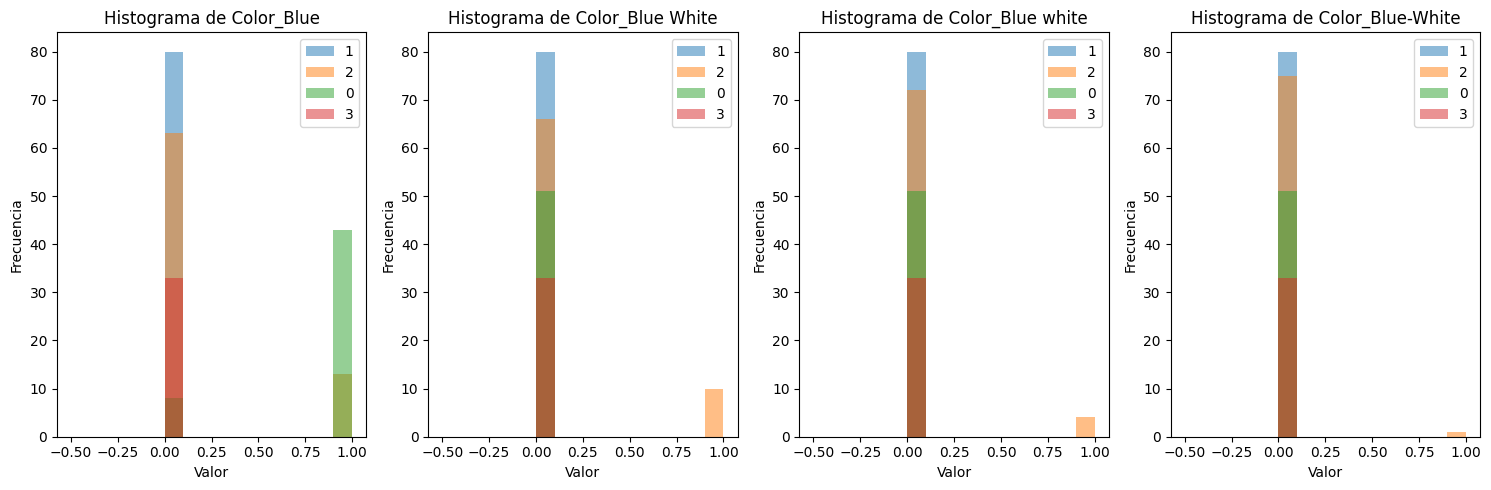

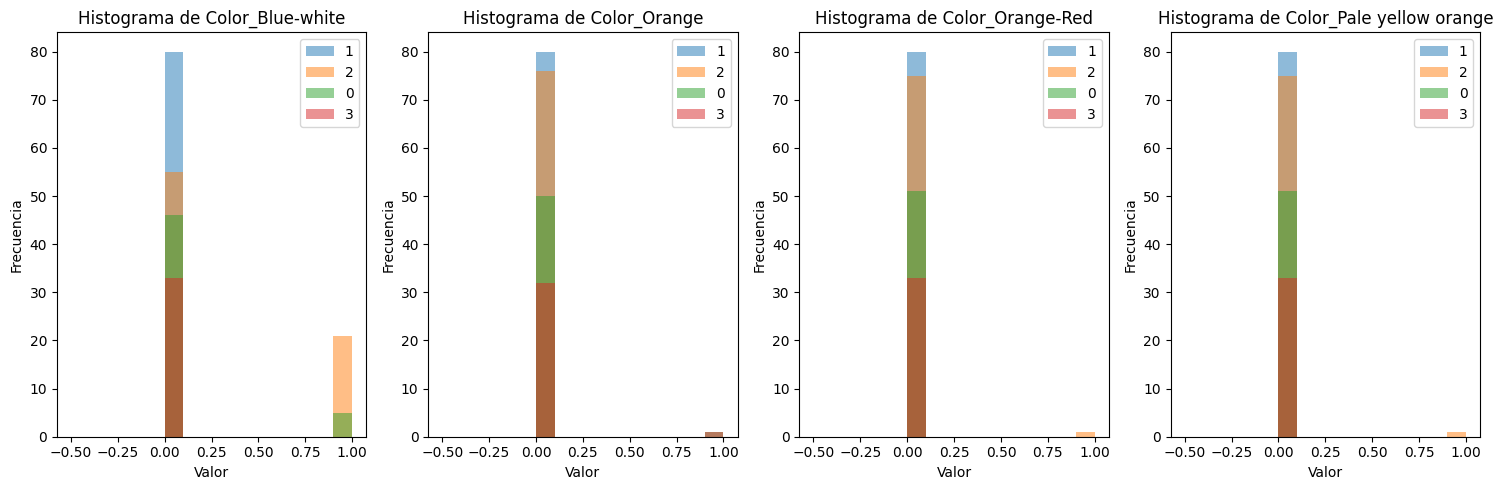

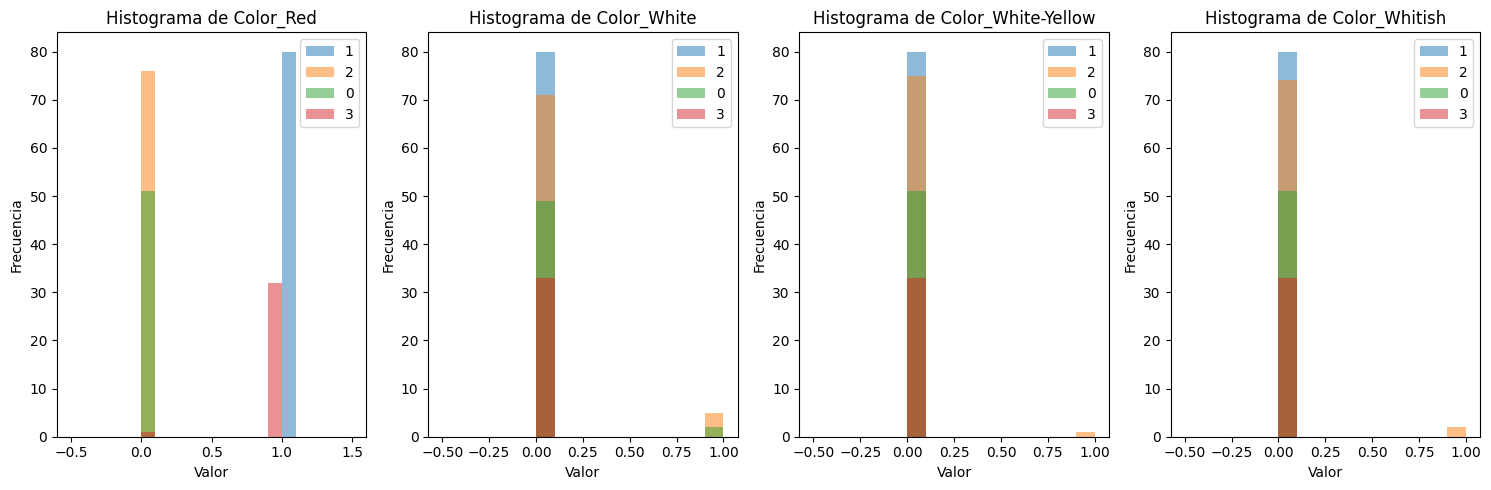

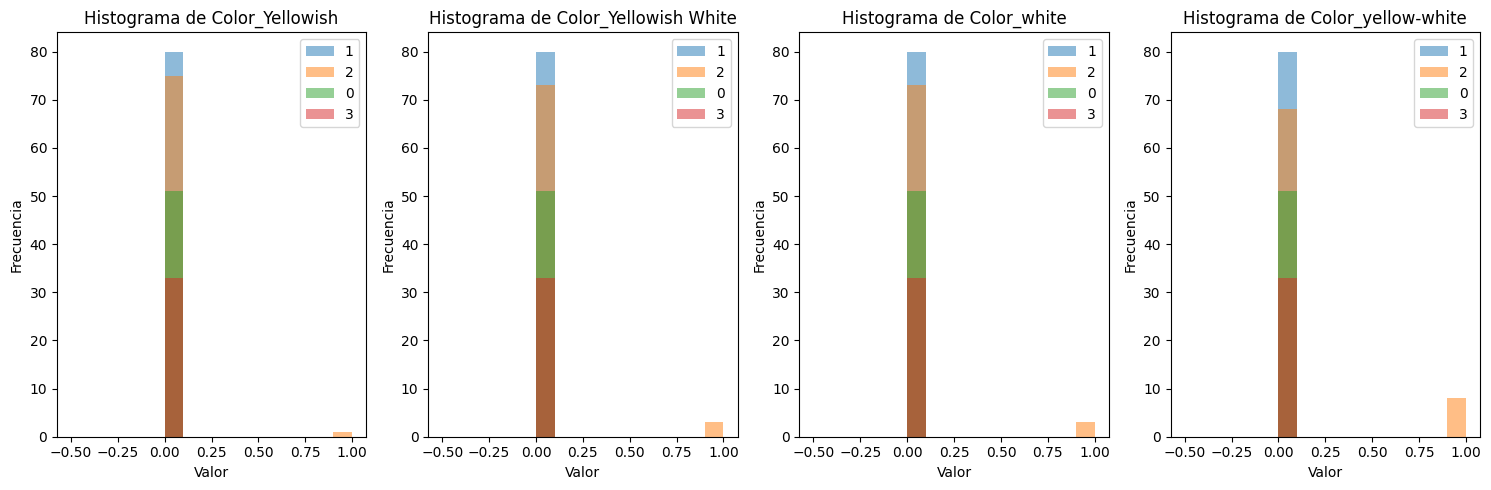

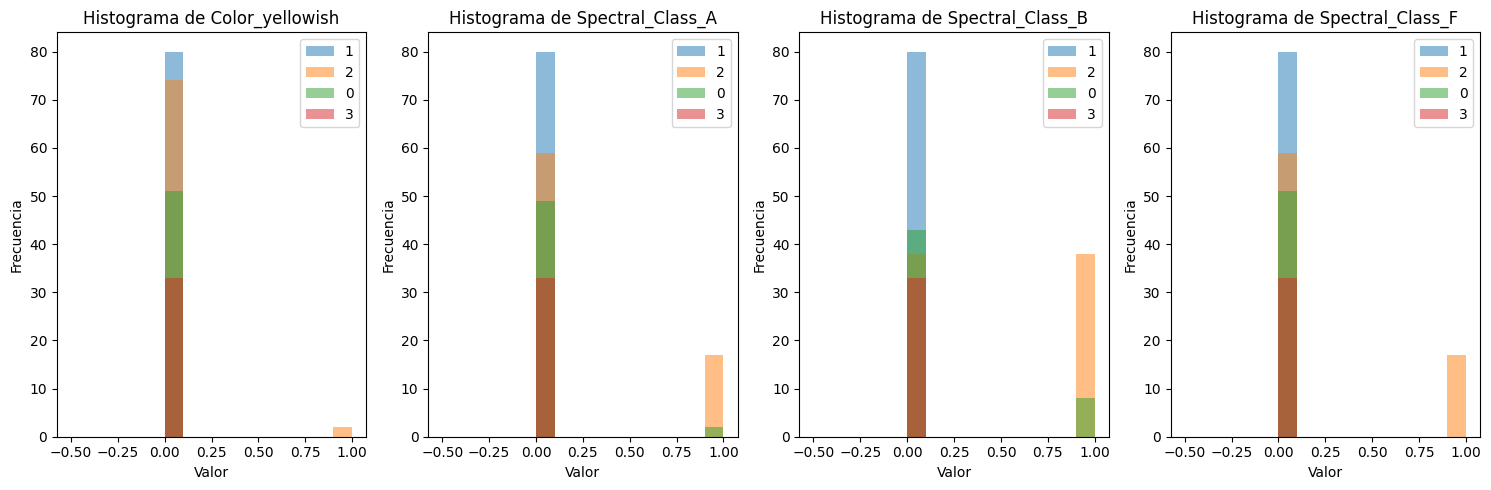

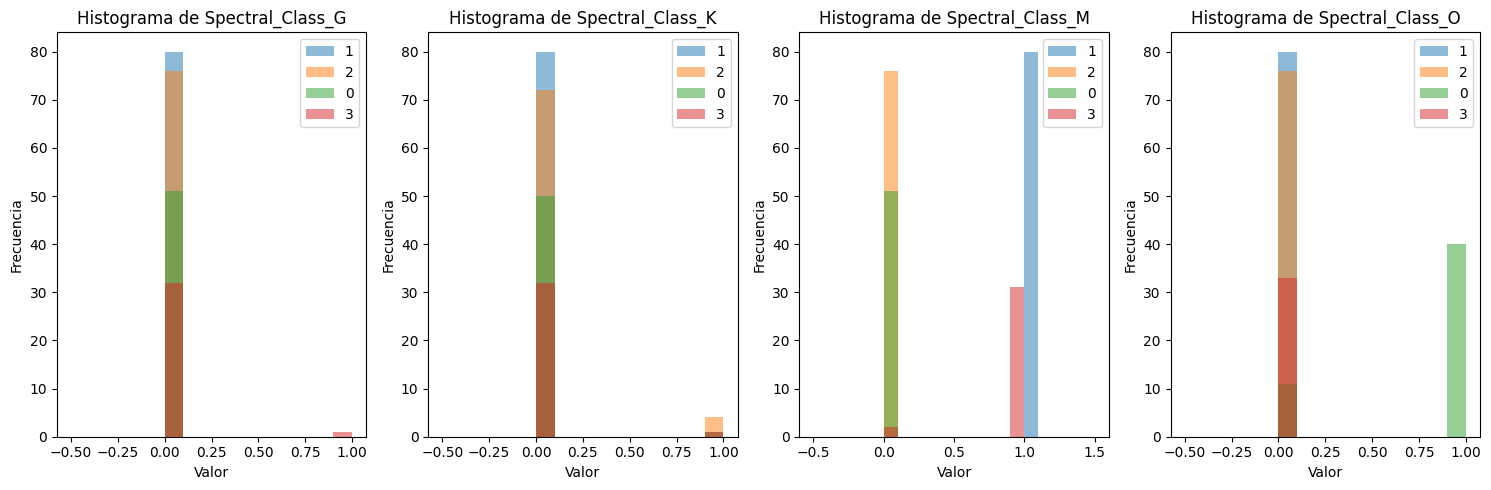

In [634]:
df = kmeans_ohe_df
labels = df['label'].unique()
column_groups = [df.columns[i:i+4] for i in range(0, len(df.columns)-1, 4)]

for group in column_groups:
    fig, axs = plt.subplots(1, len(group), figsize=(15, 5))
    for i, column in enumerate(group):
        for label in labels:
            axs[i].hist(df[df['label'] == label][column], alpha=0.5, label=label)
        axs[i].set_title('Histograma de {}'.format(column))
        axs[i].set_xlabel('Valor')
        axs[i].set_ylabel('Frecuencia')
        axs[i].legend()
    plt.tight_layout()
    plt.show()

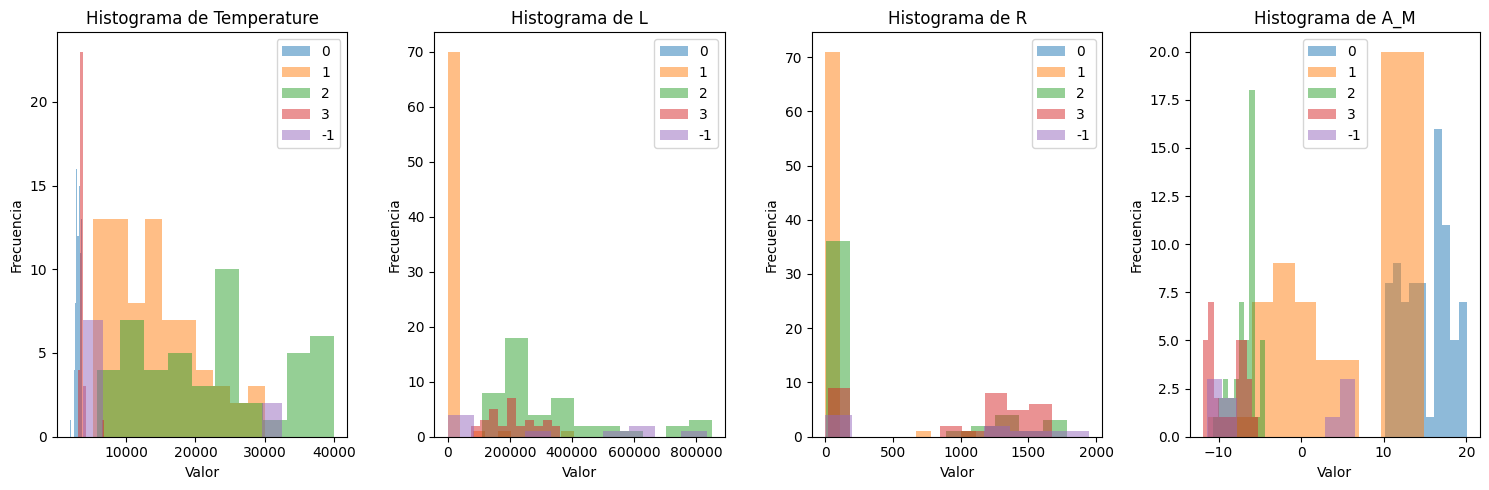

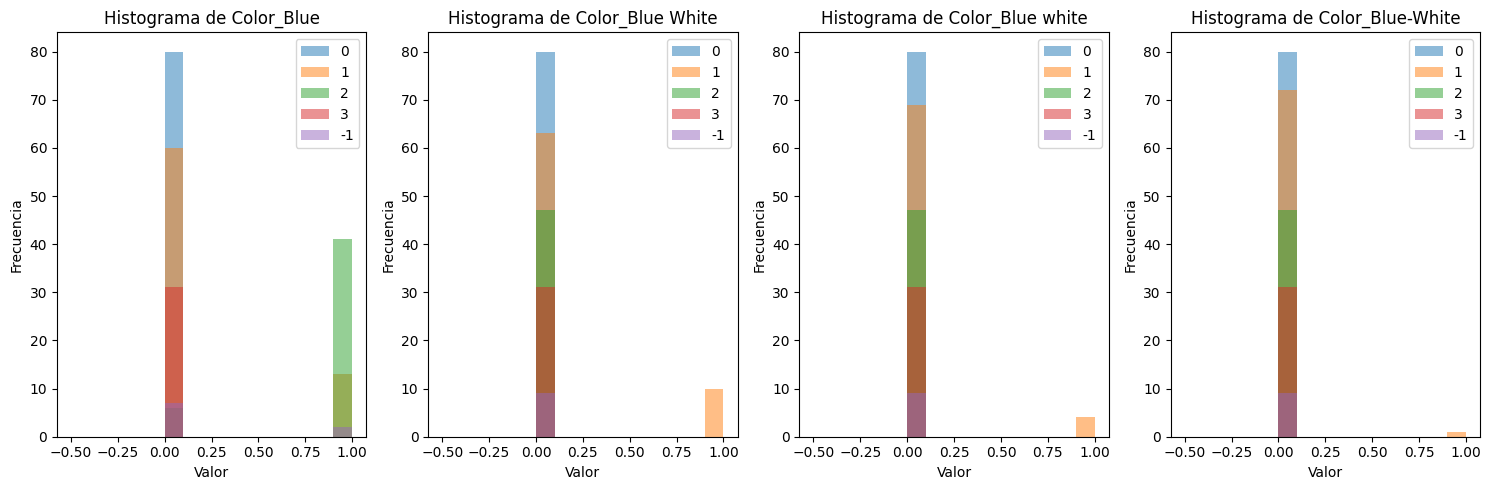

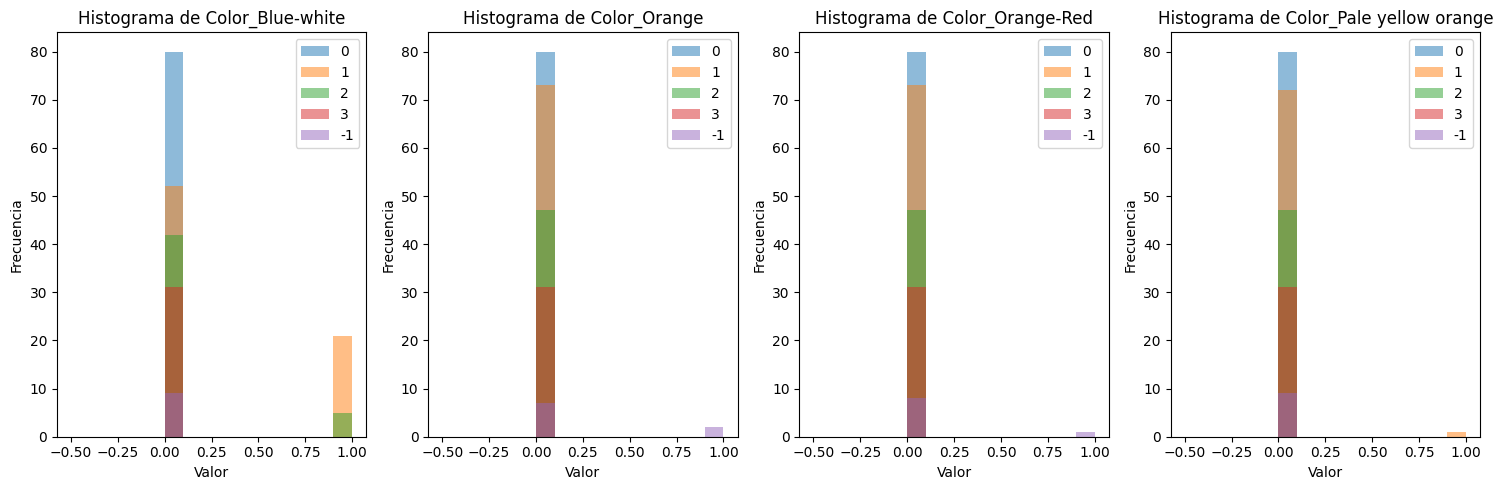

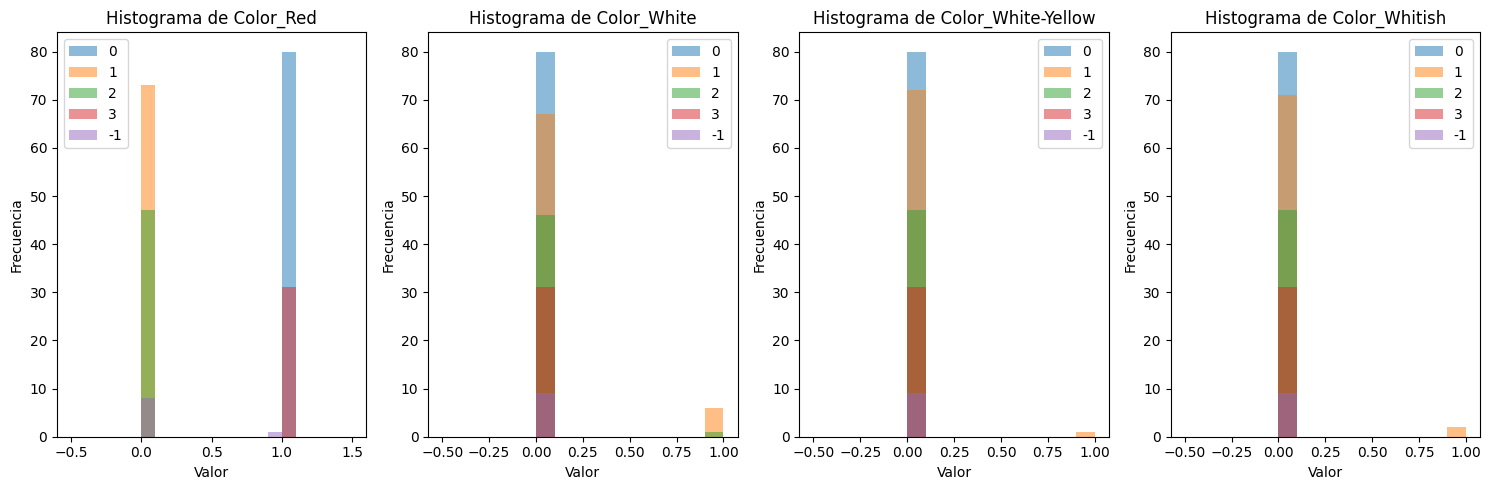

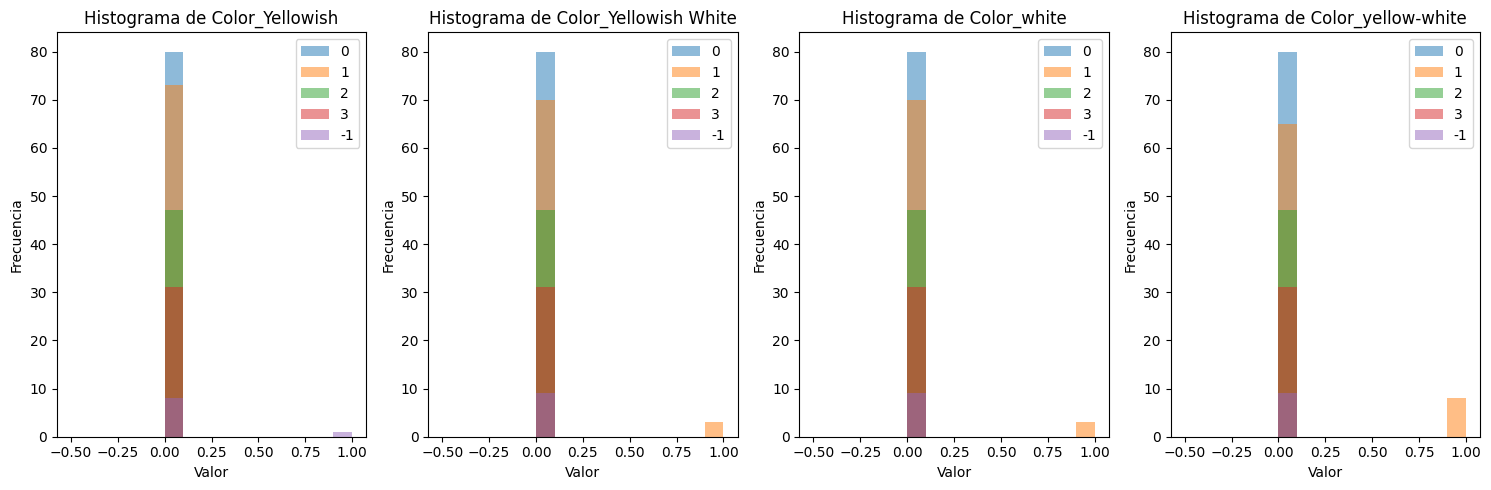

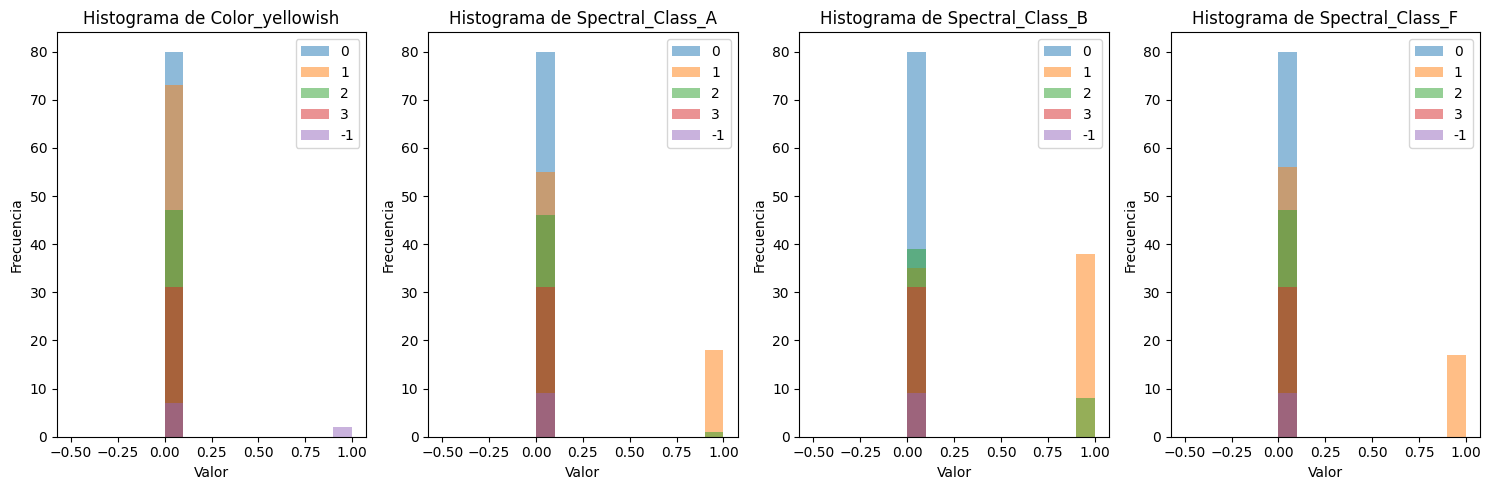

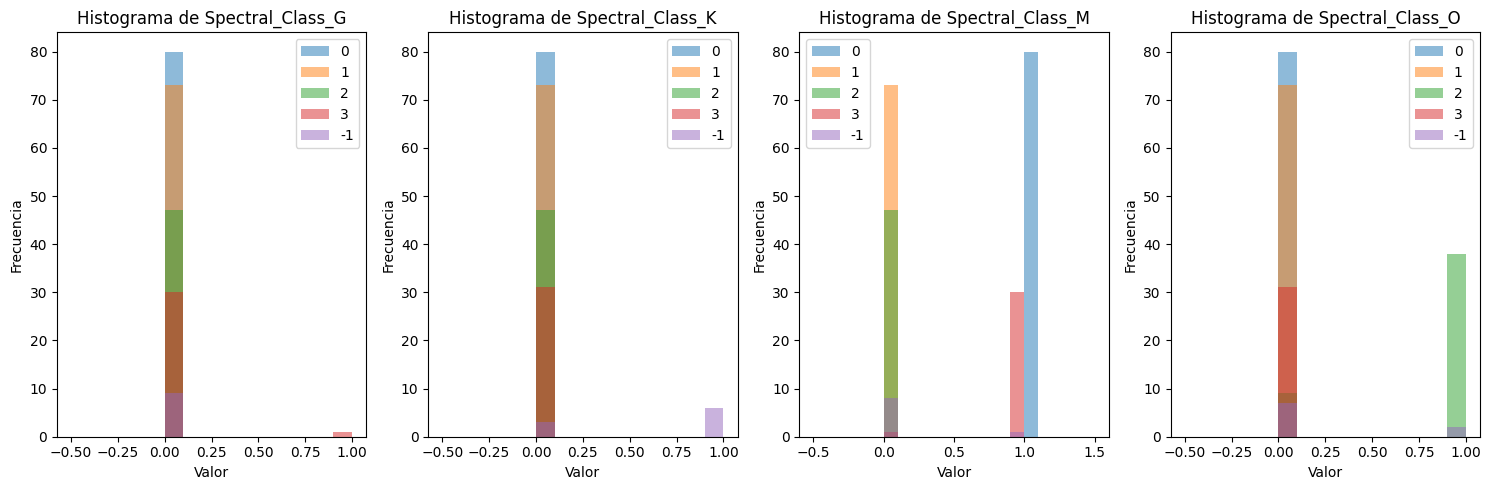

In [635]:
df = dbscan_ohe_df
labels = df['label'].unique()
column_groups = [df.columns[i:i+4] for i in range(0, len(df.columns)-1, 4)]

for group in column_groups:
    fig, axs = plt.subplots(1, len(group), figsize=(15, 5))
    for i, column in enumerate(group):
        for label in labels:
            axs[i].hist(df[df['label'] == label][column], alpha=0.5, label=label)
        axs[i].set_title('Histograma de {}'.format(column))
        axs[i].set_xlabel('Valor')
        axs[i].set_ylabel('Frecuencia')
        axs[i].legend()
    plt.tight_layout()
    plt.show()

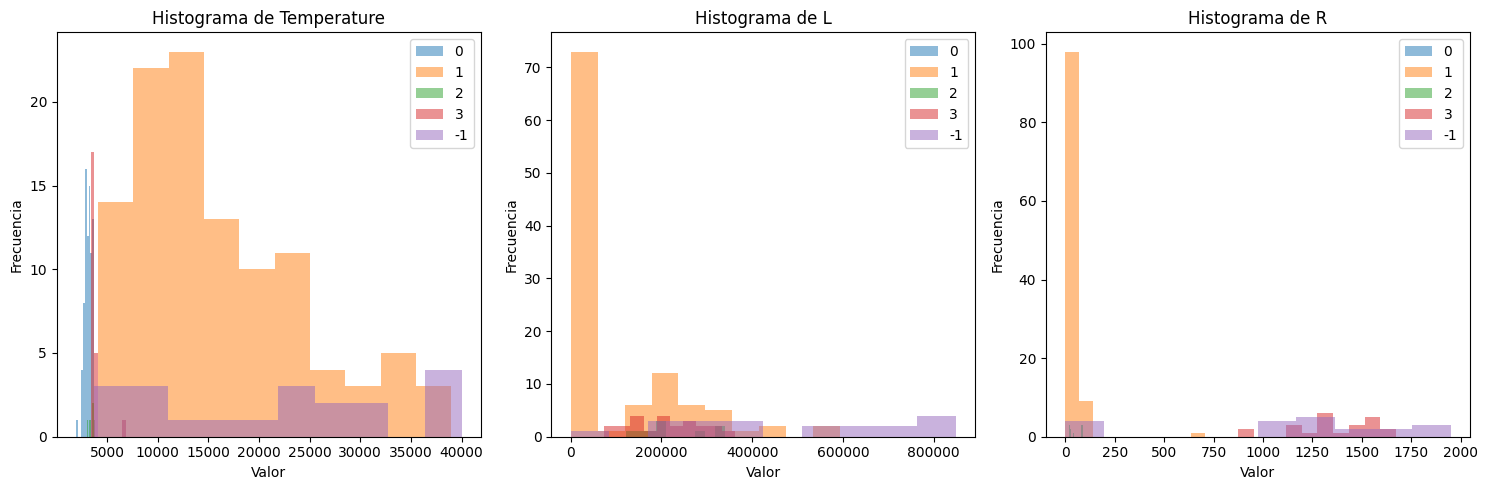

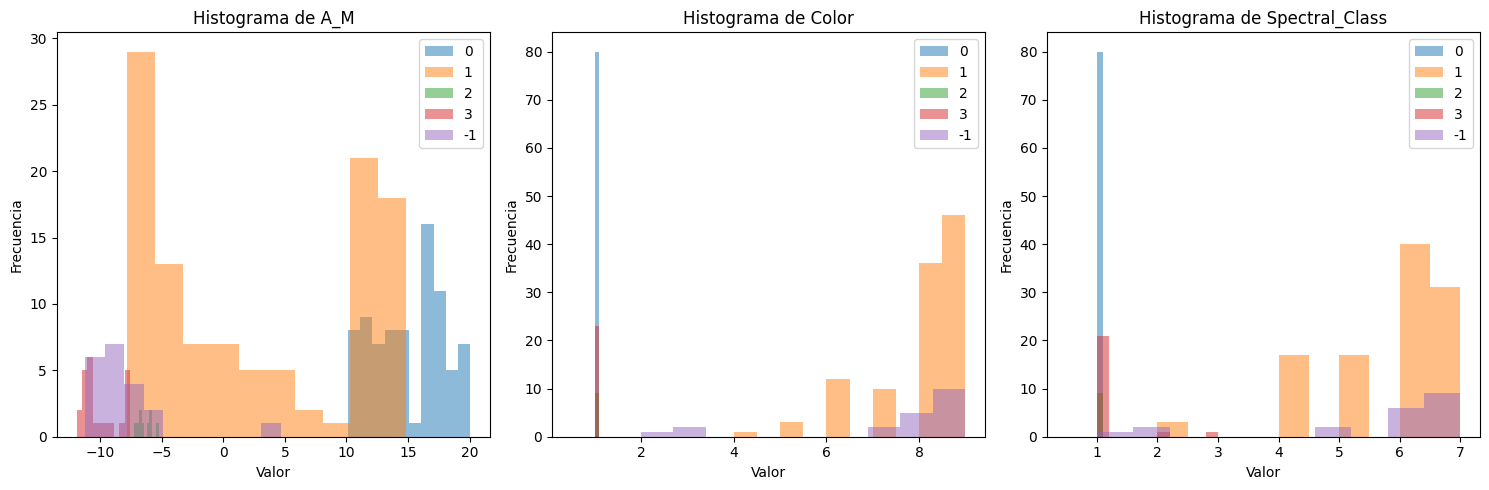

In [636]:
df = dbscan_ord_df
labels = df['label'].unique()
column_groups = [df.columns[i:i+3] for i in range(0, len(df.columns)-1, 3)]

for group in column_groups:
    fig, axs = plt.subplots(1, len(group), figsize=(15, 5))
    for i, column in enumerate(group):
        for label in labels:
            axs[i].hist(df[df['label'] == label][column], alpha=0.5, label=label)
        axs[i].set_title('Histograma de {}'.format(column))
        axs[i].set_xlabel('Valor')
        axs[i].set_ylabel('Frecuencia')
        axs[i].legend()
    plt.tight_layout()
    plt.show()

En los histogramas, se puede observar un mayor solapamiento en los métodos que utilizan 4 clústers. En su lugar, en el caso de kmeans con uso de variables ordinales (que obtiene 6 clústers), se puede ver un menor solapamiento, lo que nos indica una separación más clara entre los grupos. 
Los otros coeficientes empleados son relativamente parecidos entre los cuatro métodos, y, como tampoco son totalmente representativos de la bonanza de un modelo de clustering (nos indican cómo de separados están los clústers y cómo de cohesionados se encuentran internamente, pero no necesariamente nos indican que una tarea de clasificación arroja mejores resultados sobre los datos de inicio.), nos hemos decantado por el uso de kmeans con variables ordinales para los atributos categóricos y por tanto, el pipeline completo tiene las siguientes características:

    - Modelo kmeans
    - Variables ordinales para atributos categóricos
    - 6 clústers
    - Standard Scaler

## 6. Comparación con el Conocimiento del Dominio

En esta sección se compara los resultados obtenidos con la tabla proporcionada que da información acerca de los diferentes tipos de estrellas para el modelo elegido. En primer lugar, para poder comparar con la tabla proporcionada, se ha decidido eliminar los outliers para que las medias no queden concicionadas por casos extremos y se pueda hacer una comparativa más realista. Para ello se utilizan los z-scores para cada columna de cada cluster, de manera que los datos extremos queden fuera del cálculo de la media.

In [637]:
def calculate_mean_without_outliers(df):
    # Initialize an empty dataframe to store means without outliers
    means_without_outliers = pd.DataFrame(index=df.columns.drop('label'), columns=df['label'].unique())
    
    # Group by label
    grouped = df.groupby('label')
    for label, group in grouped:
        # Calculate Z-score for each feature in the group
        z_scores = stats.zscore(group.drop(columns=['label']))
        # Define threshold for outlier detection (e.g., |Z| > 3)
        threshold = 3
        # Identify outliers based on Z-score
        outliers = (abs(z_scores) > threshold).any(axis=1)
        # Exclude outliers
        filtered_group = group[~outliers]
        # Calculate mean for each feature
        mean_without_outliers = filtered_group.drop(columns=['label']).mean()
        # Store mean without outliers for the current label
        means_without_outliers[label] = mean_without_outliers
    
    return means_without_outliers.transpose()

kmeans_ord_means = calculate_mean_without_outliers(kmeans_ord_df)
kmeans_ord_means

,Temperature,L,R,A_M,Color,Spectral_Class
1,3140.887500,0.003050,0.229080,15.051738,1.000000,1.000000
3,12499.610169,99.869886,1.099239,8.694729,7.644068,5.169492
0,22029.780488,205251.658537,36.883585,-5.496951,8.780488,6.731707
2,3566.133333,214233.333333,1007.500000,-9.062333,1.000000,1.033333
5,32196.111111,620537.222222,1125.055556,-8.591778,8.777778,6.777778
4,15835.666667,404194.000000,1085.722222,-8.869556,8.222222,6.111111


Se crea un DataFrame con el conocimiento que tenemos (tabla del enunciado) para poder hacer una comparación

In [638]:
tabla = [
    [3000, 0.0007, 0.1, 17.5, 1, 1.5],
    [3300, 0.0055, 0.35, 12.5, 1, 2],
    [14000, 0.0025, 0.01, 12.6, 7, 4.5],
    [16000, 32000, 4.4, -0.4, 6, 3.5],
    [15000, 300000, 50, -6.4, 6, 3.5],
    [11000, 300000, 1400, -9.6, 5, 3.5]
]
clusters = ['Enana roja', 'Enana marrón', 'Enana blanca', 'Estrella en secuencia principal', 'Super gigante', 'Hiper gigante']
vars = ['Temperature', 'L', 'R', 'A_M', 'Color', 'Spectral_Class']


table_clusters = []
# Creamos el diccionario que contiene todos los datos de la tabla
for i, cluster_values in enumerate(tabla, start=1):
    standard_cluster = {'Cluster': clusters[i-1]}
    for j, value in enumerate(cluster_values):
        standard_cluster[f'{vars[j]}'] = value
    table_clusters.append(standard_cluster)

A continuación queda implementada una función que asigna a cada uno de los clusters obtenidos uno de los grupos que conocemos, basándose en la distancia euclídea entre las medias obtenidas y las de la tabla. Esta cercanía o similitud está calculada sin introducir pesos a cada una de las variables, debido a que, hemos decidido establecer que todas las características tienen la misma importancia a la hora de clasificar las estrellas. 

In [639]:
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

def map_clusters(clustering_results, standard_clusters):
    # Esta función hace una asignación de los clusters al grupo más parecido de la tabla (menor distancia)
    mapping = {}

    assigned_standard_clusters = set()
    for index, cluster_row in clustering_results.iterrows():
        cluster_values = cluster_row.values
        min_distance = float('inf')
        assigned_cluster = None
        for standard_cluster in standard_clusters:
            standard_cluster_values = np.array([standard_cluster[key] for key in standard_cluster.keys() if key != 'Cluster'])
            cluster_values = scale(cluster_values)
            standard_cluster_values = scale(standard_cluster_values)
            distance = euclidean_distance(cluster_values, standard_cluster_values)
            if distance < min_distance:
                min_distance = distance
                assigned_cluster = standard_cluster['Cluster']
        mapping[index] = assigned_cluster

        assigned_standard_clusters.add(assigned_cluster)
    return mapping

# Map clusters
cluster_mapping = map_clusters(kmeans_ord_means, table_clusters)
cluster_mapping

{1: 'Enana roja',
 3: 'Enana blanca',
 0: 'Super gigante',
 2: 'Hiper gigante',
 5: 'Super gigante',
 4: 'Hiper gigante'}

A continuación se crea una tabla que muestra el porcentaje de error que aparece para cada uno de los clústers con el más parecido.

In [640]:
distances = {}
table_clusters = pd.DataFrame(table_clusters)
for label in cluster_mapping.keys():
    distances[label] = []
    for var in range(len(vars)):
        media = table_clusters[table_clusters['Cluster'] == cluster_mapping[label]]
        media = media.iloc[0][vars[var]]
        distances[label].append(np.abs((kmeans_ord_means.loc[label, vars[var]] - media) / media))
        distances[label][-1] = "{:.2f} %".format(distances[label][-1] * 100)
distances_df = pd.DataFrame(distances.values(), columns=vars, index=distances.keys())
distances_df

,Temperature,L,R,A_M,Color,Spectral_Class
1,4.70 %,335.64 %,129.08 %,13.99 %,0.00 %,33.33 %
3,10.72 %,3994695.43 %,10892.39 %,30.99 %,9.20 %,14.88 %
0,46.87 %,31.58 %,26.23 %,14.11 %,46.34 %,92.33 %
2,67.58 %,28.59 %,28.04 %,5.60 %,80.00 %,70.48 %
5,114.64 %,106.85 %,2150.11 %,34.25 %,46.30 %,93.65 %
4,43.96 %,34.73 %,22.45 %,7.61 %,64.44 %,74.60 %


En esta última tabla podemos ver que el clustering deja algunas dudas en ciertos clusters. Por ejemplo, vemos un valor demasiado dispar en el valor de L para nuestro cluster 3, que fue clasificado como "Enana Blanca". En general, los valores para L y R presentan unos errores superiores al resto de parámetros, lo que puede indicar ciertos sesgos en las medidas o un defecto en el modelo. Por otro lado, se ve que otras características arrojan errores menores, como por ejemplo la magnitud absoluta, el color o la temperatura. 

Por otro lado, hemos observado que, si no restringimos la asociación de los clusters, es decir, si asociamos cada uno de los clusteres obtenidos a su grupo más parecido (sin establecer que cada grupo esté asociado a un clúster sin repeticiones), nos aparecen 4 grupos (Enana Blanca, Enana Roja, Hiper Gigante y Super Gigante). Esto puede deberse a que se está utilizando una métrica de similitud que no es la apropiada (como decíamos antes, tal vez sea necesario introducir pesos para calcular la distancia entre los puntos), o tal vez se deba a que en el dataset realmente hay datos sobre 4 grupos, en lugar de 6.

Sin embargo, en la tabla de los porcentajes, se puede observar que en la mayoría de los valores se encuentra un error menor del 50%, lo que nos sugiere que la asociación de los clústers a los grupos conocidos de estrellas es razonable. Por tanto, creemos que, aunque existen algunos puntos de mejora, los resultados obtenidos con el pipeline del punto 4 guardan cierta similitud con los datos de la tabla proporcionada.